In [56]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import sys
sys.path.append("../scripts/twitter")
from searchTwitter import TwitterDataFrame
import utils as ut

# ML imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression


In [44]:
def concat_data(base_dir):
    files = os.listdir(base_dir)
    dfs = []
    for f in files:
        dfs.append(pd.read_csv(base_dir + f))
        
    return pd.concat(dfs)

health_df = concat_data('../data/san_francisco/')
health_df.head()

C:\Users\Nick\AppData\Local\Temp/ipykernel_9496/1872091701.py:5: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(base_dir + f))


,id,author_id,text,geo,created_at,lat,lon
0,968999128641323008,25624940,@Volker_E Am I hallucinating that you are walk...,{'place_id': '5a110d312052166f'},2018-02-28 23:59:30,37.708075,-122.514926
1,968999100757680128,8888,There’s just something weird about living in N...,{'place_id': '5ef5b7f391e30aff'},2018-02-28 23:59:23,37.845953,-122.324818
2,968999065273774080,1557223812,Tomorrow’s March sheeeesh I’m basically 24 😕 t...,{'place_id': '5ecbd073f39c00fa'},2018-02-28 23:59:14,37.592632,-122.160814
3,968999056537088000,1164993320,Wednesday really be draining 6-6 school day 😴,{'place_id': '5ecbd073f39c00fa'},2018-02-28 23:59:12,37.592632,-122.160814
4,968999038493245440,18650764,@remedy415 @Brycesavoy510 This hella dope,{'place_id': 'ab2f2fac83aa388d'},2018-02-28 23:59:08,37.699279,-122.342660


In [45]:
# Turn into a TwitterDataFrame and zoom in on san francisco
health_df = TwitterDataFrame(health_df)
lat = (37, 39)
lon = (-121, -124)
sf_df = health_df.zoom_in(lat, lon)

In [46]:
# Take a random subsample of the dataframe to reduce the size
sf_df = sf_df.sample(32000, replace=True)

# Ideally this should be before sampling but this way saves time
# Could this happen in TwitterDataFrame?
sf_df['created_at'] = [datetime.strptime(d,'%Y-%m-%d %H:%M:%S') for d in sf_df['created_at']]

# Subset 5/2018-12/2018
sf_df = sf_df[sf_df['created_at'] > datetime(2018, 4, 30)]

sf_df = TwitterDataFrame(sf_df)
sf_df.head()

In [47]:
# What are the basics of this data set?
print("Lenth: ", len(sf_df))
print("Per day :", len(sf_df)/365)

Lenth:  32000
Per day : 87.67123287671232


Text(0.5, 0, 'Date')

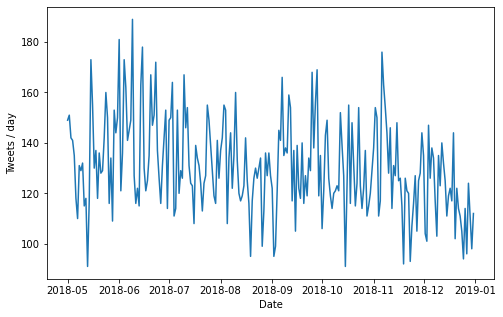

In [48]:
# Plot num tweets per day by date
plt.figure(figsize=(8,5))
plt.plot(sf_df.count_by_day())
ax = plt.gca()
ax.set_ylabel("Tweets / day")
ax.set_xlabel("Date")

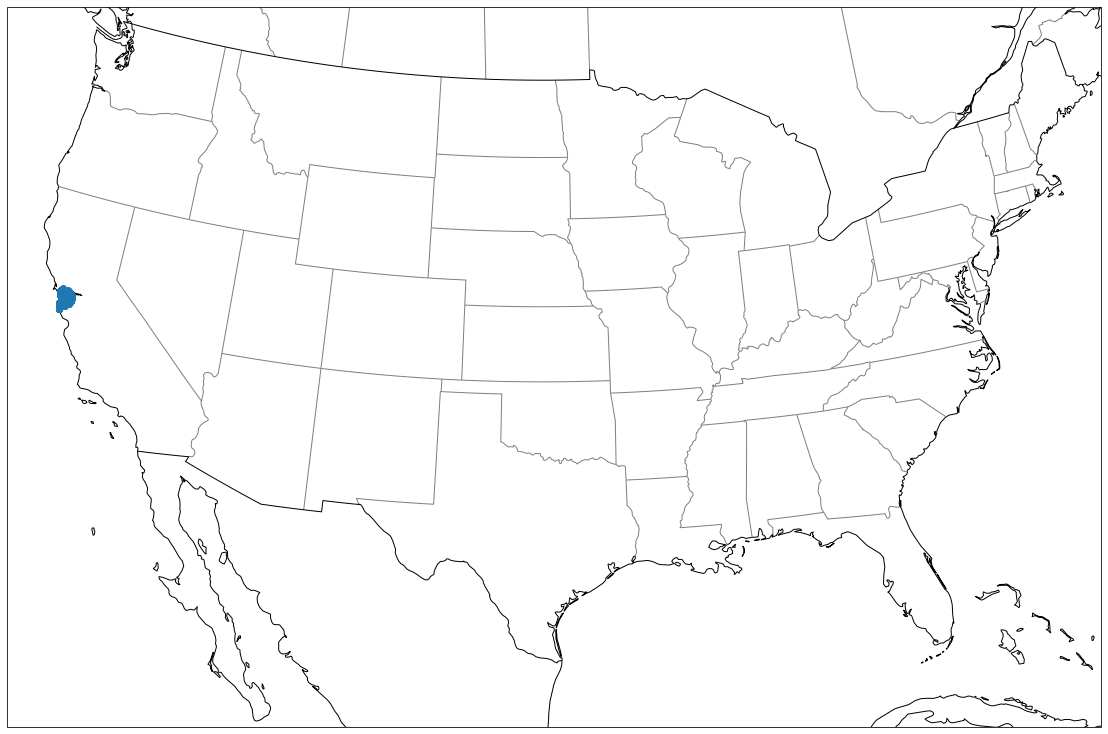

In [49]:
import cartopy
import cartopy.feature as cfeature
fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0, 0, 1, 1], projection=cartopy.crs.LambertConformal(central_longitude=-98.0))
ax.set_extent((-120, -75,21, 50), cartopy.crs.Geodetic())
ax.coastlines()

# Add state boundaries
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS)
ax.scatter(sf_df['lon'],sf_df['lat'], transform=cartopy.crs.PlateCarree())
# plt.show()

In [50]:
aqi_2018 = pd.read_csv('../data/daily_aqi_by_county_2018.csv')
ca_aqi = aqi_2018[(aqi_2018['State Name']=='California') & (aqi_2018['county Name']=='San Francisco')]
ca_aqi.head()

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
27443,California,San Francisco,6,75,2018-01-01,72,Moderate,PM2.5,06-075-0005,1
27444,California,San Francisco,6,75,2018-01-02,82,Moderate,PM2.5,06-075-0005,1
27445,California,San Francisco,6,75,2018-01-03,111,Unhealthy for Sensitive Groups,PM2.5,06-075-0005,1
27446,California,San Francisco,6,75,2018-01-04,58,Moderate,PM2.5,06-075-0005,1
27447,California,San Francisco,6,75,2018-01-05,26,Good,NO2,06-075-0005,1


In [58]:
# Vectorize data
tf_vect = TfidfVectorizer(min_df=1, stop_words="english")
X_enc = tf_vect.fit_transform(sf_df['text'])

# Run trunvated SVD on the vector encodings
svd = TruncatedSVD(n_components=20)
svd_lsa = svd.fit_transform(X_enc)

print(svd_lsa.shape)

(32000, 20)


Text(0.5, 1.0, 'First Two Dimensions of SVD Encoding')

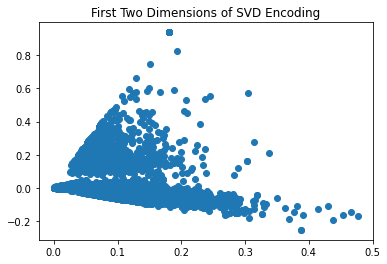

In [59]:
# Scatter the results
plt.scatter(svd_lsa[:, 0], svd_lsa[:, 1])
plt.title("First Two Dimensions of SVD Encoding")